In [1]:
import torch

from models.predictionnet import ResBlock, UpSample, DownSample, AttentionBlock, DownBlock, UpBlock, MidBlock, PadBlock, UnPadBlock, UNet

from matplotlib import pyplot as plt

torch.Size([4, 64, 180, 90]) torch.Size([4, 64, 180, 90])


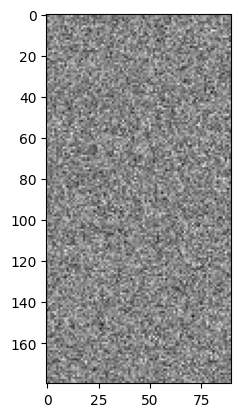

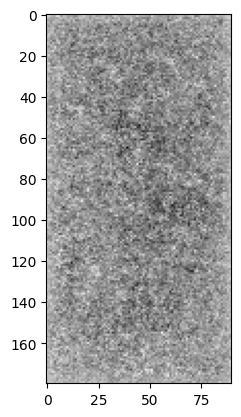

In [ ]:
def main():
    input = torch.randn(4, 64, 180, 90).to("cuda")

    unet = UNet(

        in_channels=64,

        base_channels=256,

        channels_mult=[1, 1, 2, 2, 4],

        num_resblocks=2,

        attention_layers=[False, False, True, True, True],

        pads=(3, 3, 6, 6)
    ).to("cuda")

    x = unet(input)

    print(input.shape, x.shape)

    plt.imshow(input[0, 0].detach().cpu().numpy(), cmap="gray")

    plt.show()

    plt.imshow(x[0, 0].detach().cpu().numpy(), cmap="gray")

    plt.show()

    torch.cuda.empty_cache()


if __name__ == "__main__":
    main()

In [1]:
import xarray as xr
import numpy as np
import dask.array as da
import pandas as pd

x_cord = np.arange(0, 180, 1)
y_cord = np.arange(0, 90, 1)
channel_cord = np.arange(0, 64, 1)
time_cord = pd.date_range("2000-01-01", periods=300, freq="6h")

path = "zarr_files/test.zarr"

dataset = xr.Dataset(
    coords={
        "time": (["time"], time_cord),
        "x": (["x"], x_cord),
        "y": (["y"], y_cord),
        "channel": (["channel"], channel_cord),
    },
    data_vars={
        "data": (
            ["time", "channel", "x", "y"],
            da.zeros(
                (time_cord.size, channel_cord.size, x_cord.size, y_cord.size),
                chunks=(1, 64, 180, 90),
                dtype="float32",
            ),
        )
    },
)

dataset.to_zarr(path, compute=False, mode="w", zarr_format=3,
                consolidated=False, encoding={"data": {"dtype": "float32"}})
dataset

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 300, channel: 64, x: 180, y: 90)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2000-01-01 ... 2000-03-15T18:00:00
  * x        (x) int64 1kB 0 1 2 3 4 5 6 7 8 ... 172 173 174 175 176 177 178 179
  * y        (y) int64 720B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * channel  (channel) int64 512B 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63
Data variables:
    data     (time, channel, x, y) float32 1GB dask.array<chunksize=(1, 64, 180, 90), meta=np.ndarray>

In [2]:
for date in time_cord:
    item = np.random.randn(1, 64, 180, 90)

    new_data = xr.Dataset(
        coords={
            "time": (["time"], [date]),
            "x": (["x"], x_cord),
            "y": (["y"], y_cord),
            "channel": (["channel"], channel_cord),
        },
        data_vars={
            "data": (
                ["time", "channel", "x", "y"],
                item,
            )
        },
    )

    new_data.to_zarr(path, region="auto", consolidated=False)

In [3]:
import xbatcher as xb

ds = xr.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/1959-2022-6h-64x32_equiangular_with_poles_conservative.zarr/",
    chunks=None,
    storage_options=dict(token="anon"),
)


In [ ]:
LEVEL = [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000]
VARS_SURFACE = [
    "2m_temperature",
    "10m_u_component_of_wind",
    "10m_v_component_of_wind",
    "mean_sea_level_pressure",
]
VARS_ATMOSPHERE = [
    "temperature",
    "u_component_of_wind",
    "v_component_of_wind",
    "geopotential",
    "specific_humidity",
]

ds = ds.sel(time=time_cord)
ds = ds.sel(level=LEVEL)
ds = ds[VARS_SURFACE + VARS_ATMOSPHERE]

bgen = xb.BatchGenerator(
    ds, input_dims={"time": 1, "level": 13, "latitude": 32, "longitude": 64}
)

from multiprocessing.dummy import Pool as ThreadPool

pool = ThreadPool(16)
test = pool.map_async(bgen.__getitem__, range(32))

print("moin")

test = test.get()

for i in range(32):
    print(test[i]["2m_temperature"].mean())

moin
<xarray.DataArray '2m_temperature' ()> Size: 4B
array(276.23706, dtype=float32)
<xarray.DataArray '2m_temperature' ()> Size: 4B
array(276.51303, dtype=float32)
<xarray.DataArray '2m_temperature' ()> Size: 4B
array(276.83752, dtype=float32)
<xarray.DataArray '2m_temperature' ()> Size: 4B
array(276.56665, dtype=float32)
<xarray.DataArray '2m_temperature' ()> Size: 4B
array(276.3132, dtype=float32)
<xarray.DataArray '2m_temperature' ()> Size: 4B
array(276.65863, dtype=float32)
<xarray.DataArray '2m_temperature' ()> Size: 4B
array(276.8144, dtype=float32)
<xarray.DataArray '2m_temperature' ()> Size: 4B
array(276.49332, dtype=float32)
<xarray.DataArray '2m_temperature' ()> Size: 4B
array(276.1678, dtype=float32)
<xarray.DataArray '2m_temperature' ()> Size: 4B
array(276.47058, dtype=float32)
<xarray.DataArray '2m_temperature' ()> Size: 4B
array(276.69214, dtype=float32)
<xarray.DataArray '2m_temperature' ()> Size: 4B
array(276.38748, dtype=float32)
<xarray.DataArray '2m_temperature' ()>

In [8]:
pool.close()

In [2]:
import time
from tqdm import tqdm
from multiprocessing.dummy import Pool as ThreadPool

def get_item(i):
    time.sleep(3)
    return f"Item: {i}"

NUM_SAMPLES = 320
NUM_THREADS = 16
THREAD_CHUNK_SIZE = 64

pool = ThreadPool(NUM_THREADS)
job = pool.map_async(get_item, range(0, THREAD_CHUNK_SIZE))
result = None

for i in tqdm(range(NUM_SAMPLES // THREAD_CHUNK_SIZE)):

    result = job.get()

    if i != (NUM_SAMPLES // THREAD_CHUNK_SIZE) - 1:
        job = pool.map_async(get_item, range((i + 1) * THREAD_CHUNK_SIZE, (i + 2) * THREAD_CHUNK_SIZE))

    for item in result:
        # Process the item as needed
        time.sleep(0.1)  # Simulate some processing time
        print(item)
        # Process the item as needed

    

  0%|          | 0/5 [00:00<?, ?it/s]

Item: 0
Item: 1
Item: 2
Item: 3
Item: 4
Item: 5
Item: 6
Item: 7
Item: 8
Item: 9
Item: 10
Item: 11
Item: 12
Item: 13
Item: 14
Item: 15
Item: 16
Item: 17
Item: 18
Item: 19
Item: 20
Item: 21
Item: 22
Item: 23
Item: 24
Item: 25
Item: 26
Item: 27
Item: 28
Item: 29
Item: 30
Item: 31
Item: 32
Item: 33
Item: 34
Item: 35
Item: 36
Item: 37
Item: 38
Item: 39
Item: 40
Item: 41
Item: 42
Item: 43
Item: 44
Item: 45
Item: 46
Item: 47
Item: 48
Item: 49
Item: 50
Item: 51
Item: 52
Item: 53
Item: 54
Item: 55
Item: 56
Item: 57
Item: 58
Item: 59
Item: 60
Item: 61
Item: 62


 20%|██        | 1/5 [00:18<01:13, 18.43s/it]

Item: 63
Item: 64
Item: 65
Item: 66
Item: 67
Item: 68
Item: 69
Item: 70
Item: 71
Item: 72
Item: 73
Item: 74
Item: 75
Item: 76
Item: 77
Item: 78
Item: 79
Item: 80
Item: 81
Item: 82
Item: 83
Item: 84
Item: 85
Item: 86
Item: 87
Item: 88
Item: 89
Item: 90
Item: 91
Item: 92
Item: 93
Item: 94
Item: 95
Item: 96
Item: 97
Item: 98
Item: 99
Item: 100
Item: 101
Item: 102
Item: 103
Item: 104
Item: 105
Item: 106
Item: 107
Item: 108
Item: 109
Item: 110
Item: 111
Item: 112
Item: 113
Item: 114
Item: 115
Item: 116
Item: 117
Item: 118
Item: 119
Item: 120
Item: 121
Item: 122
Item: 123
Item: 124
Item: 125
Item: 126
Item: 127


 40%|████      | 2/5 [00:30<00:43, 14.65s/it]

Item: 128
Item: 129
Item: 130
Item: 131
Item: 132
Item: 133
Item: 134
Item: 135
Item: 136
Item: 137
Item: 138
Item: 139
Item: 140
Item: 141
Item: 142
Item: 143
Item: 144
Item: 145
Item: 146
Item: 147
Item: 148
Item: 149
Item: 150
Item: 151
Item: 152
Item: 153
Item: 154
Item: 155
Item: 156
Item: 157
Item: 158
Item: 159
Item: 160
Item: 161
Item: 162
Item: 163
Item: 164
Item: 165
Item: 166
Item: 167
Item: 168
Item: 169
Item: 170
Item: 171
Item: 172
Item: 173
Item: 174
Item: 175
Item: 176
Item: 177
Item: 178
Item: 179
Item: 180
Item: 181
Item: 182
Item: 183
Item: 184
Item: 185
Item: 186
Item: 187
Item: 188
Item: 189


 60%|██████    | 3/5 [00:42<00:26, 13.44s/it]

Item: 190
Item: 191
Item: 192
Item: 193
Item: 194
Item: 195
Item: 196
Item: 197
Item: 198
Item: 199
Item: 200
Item: 201
Item: 202
Item: 203
Item: 204
Item: 205
Item: 206
Item: 207
Item: 208
Item: 209
Item: 210
Item: 211
Item: 212
Item: 213
Item: 214
Item: 215
Item: 216
Item: 217
Item: 218
Item: 219
Item: 220
Item: 221
Item: 222
Item: 223
Item: 224
Item: 225
Item: 226
Item: 227
Item: 228
Item: 229
Item: 230
Item: 231
Item: 232
Item: 233
Item: 234
Item: 235
Item: 236
Item: 237
Item: 238
Item: 239
Item: 240
Item: 241
Item: 242
Item: 243
Item: 244
Item: 245
Item: 246
Item: 247
Item: 248
Item: 249
Item: 250
Item: 251
Item: 252
Item: 253
Item: 254
Item: 255


 80%|████████  | 4/5 [00:54<00:12, 12.87s/it]

Item: 256
Item: 257
Item: 258
Item: 259
Item: 260
Item: 261
Item: 262
Item: 263
Item: 264
Item: 265
Item: 266
Item: 267
Item: 268
Item: 269
Item: 270
Item: 271
Item: 272
Item: 273
Item: 274
Item: 275
Item: 276
Item: 277
Item: 278
Item: 279
Item: 280
Item: 281
Item: 282
Item: 283
Item: 284
Item: 285
Item: 286
Item: 287
Item: 288
Item: 289
Item: 290
Item: 291
Item: 292
Item: 293
Item: 294
Item: 295
Item: 296
Item: 297
Item: 298
Item: 299
Item: 300
Item: 301
Item: 302
Item: 303
Item: 304
Item: 305
Item: 306
Item: 307
Item: 308
Item: 309
Item: 310
Item: 311
Item: 312
Item: 313
Item: 314
Item: 315
Item: 316
Item: 317
Item: 318


100%|██████████| 5/5 [01:06<00:00, 13.29s/it]

Item: 319


In [7]:
import xarray as xr
import numpy as np
import pandas as pd
import xbatcher as xb

TIME_START = "2000-01-01"
NUM_SAMPLES = 16

x_cord = np.arange(0, 180, 1)
y_cord = np.arange(0, 90, 1)
channel_cord = np.arange(0, 64, 1)
time_cord = pd.date_range(TIME_START, periods=NUM_SAMPLES, freq="6h")

ds = xr.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3",
    chunks=None,
    storage_options=dict(token="anon"),
)

LEVEL = [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000]
VARS_SURFACE = [
    "2m_temperature",
    "10m_u_component_of_wind",
    "10m_v_component_of_wind",
    "mean_sea_level_pressure",
]
VARS_ATMOSPHERE = [
    "temperature",
    "u_component_of_wind",
    "v_component_of_wind",
    "geopotential",
    "specific_humidity",
]

ds = ds.sel(time=time_cord)
ds = ds.sel(level=LEVEL)
ds = ds[VARS_SURFACE + VARS_ATMOSPHERE]

bgen = xb.BatchGenerator(
    ds, input_dims={"time": 1, "level": 13, "latitude": 721, "longitude": 1440}
)

In [8]:
item = bgen[0]

In [12]:
item.time.values[0]

np.datetime64('2000-01-01T00:00:00.000000000')

In [13]:
ds = xr.open_zarr("zarr_files/latent_vae-kl-f8.zarr/", consolidated=False)
ds

<xarray.Dataset> Size: 66MB
Dimensions:  (channel: 64, time: 16, x: 180, y: 90)
Coordinates:
  * channel  (channel) int64 512B 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63
  * time     (time) datetime64[ns] 128B 2000-01-01 ... 2000-01-04T18:00:00
  * y        (y) int64 720B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * x        (x) int64 1kB 0 1 2 3 4 5 6 7 8 ... 172 173 174 175 176 177 178 179
Data variables:
    data     (time, channel, x, y) float32 66MB dask.array<chunksize=(1, 64, 180, 90), meta=np.ndarray>

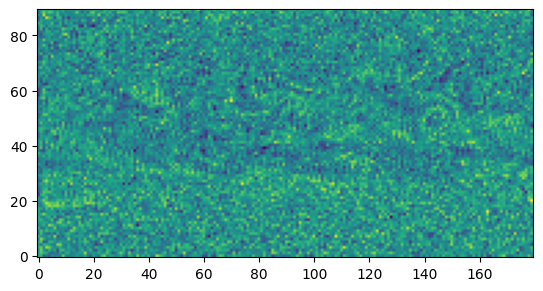

In [62]:
item = ds.isel(time=4).data.compute()

from matplotlib import pyplot as plt

plt.imshow(item[36].T, origin="lower")
plt.show()